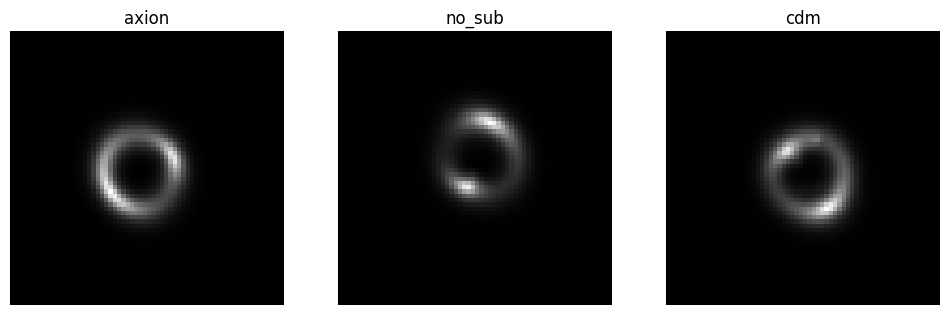

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define dataset paths
task4_path = "/kaggle/input/foundational-model-task-ml4sci/Task4/Dataset"
task4b_path = "/kaggle/input/foundational-model-task-ml4sci/Task4-b/Dataset"

# Define categories
categories = ["axion", "no_sub", "cdm"]

# Function to load a random sample from a given category
def load_random_sample(category):
    category_path = os.path.join(task4_path, category)
    file_list = [f for f in os.listdir(category_path) if f.endswith(".npy")]
    if not file_list:
        raise ValueError(f"No .npy files found in {category_path}")
    random_file = np.random.choice(file_list)
    return np.load(os.path.join(category_path, random_file),allow_pickle=True)

# Visualize sample images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, category in enumerate(categories):
    sample_image = load_random_sample(category)
    if sample_image.ndim!=2:
        sample_image=sample_image[0]
    axes[i].imshow(sample_image, cmap="gray")
    axes[i].set_title(category)
    axes[i].axis("off")
plt.show()


<ipython-input-2-b3e9ab4d8259>:31: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_map = self._compute_entropy(img)


torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


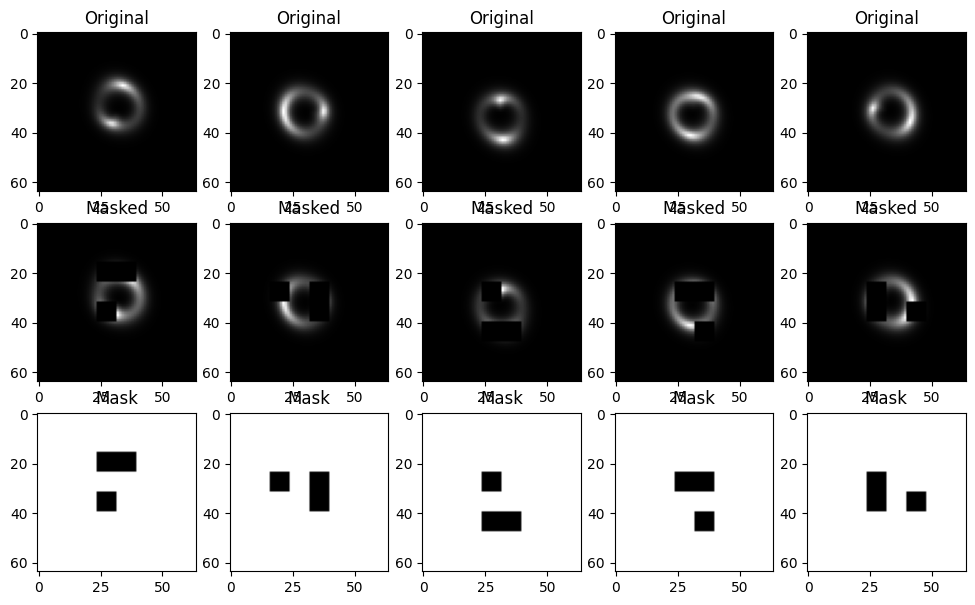

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset
from skimage.filters.rank import entropy
from skimage.morphology import disk

class MaskedLensingDataset(Dataset):
    def __init__(self, data_dir, mask_ratio=0.05, patch_size=8, transform=None):
        self.data_dir = data_dir
        self.file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def _compute_entropy(self, img):
        """Compute local entropy to determine information density."""
        return entropy(img, disk(3))

    def _apply_mask(self, img):
        """Apply an information-based mask to the image."""
        H, W = img.shape
        num_patches_h, num_patches_w = H // self.patch_size, W // self.patch_size

        # Compute entropy map
        entropy_map = self._compute_entropy(img)

        # Divide into patches
        patches = []
        patch_coords = []
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y1, y2 = i * self.patch_size, (i + 1) * self.patch_size
                x1, x2 = j * self.patch_size, (j + 1) * self.patch_size
                patch_entropy = entropy_map[y1:y2, x1:x2].mean()
                patches.append((patch_entropy, (y1, y2, x1, x2)))
        
        # Sort patches by entropy
        patches.sort(reverse=True, key=lambda x: x[0])

        # Mask the top mask_ratio% highest-entropy patches
        num_masked = int(len(patches) * self.mask_ratio)
        mask = np.ones_like(img)
        for _, (y1, y2, x1, x2) in patches[:num_masked]:
            mask[y1:y2, x1:x2] = 0  # Apply mask

        return img * mask, mask  # Return masked image and the mask itself

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = np.load(img_path).astype(np.float32)  # Load .npy file
        img = (img - img.min()) / (img.max() - img.min())  # Normalize
        
        masked_img, mask = self._apply_mask(img)

        

        if self.transform:
            img = self.transform(img)
            masked_img = self.transform(masked_img)
            mask = self.transform(mask)

        # img,masked_img,mask=img.unsqueeze(0),masked_img.unsqueeze(0),mask.unsqueeze(0)

        return masked_img, img, mask  # Return masked image, original image, and mask

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MaskedLensingDataset(data_dir="/kaggle/input/foundational-model-task-ml4sci/Task4/Dataset/no_sub", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Save some sample masked images
import matplotlib.pyplot as plt

for masked_imgs, orig_imgs, masks in dataloader:
    print(masked_imgs.shape, orig_imgs.shape, masks.shape)
    fig, axs = plt.subplots(3, 5, figsize=(12, 7))
    for i in range(5):
        axs[0, i].imshow(orig_imgs[i][0], cmap='gray')
        axs[0, i].set_title("Original")
        axs[1, i].imshow(masked_imgs[i][0], cmap='gray')
        axs[1, i].set_title("Masked")
        axs[2, i].imshow(masks[i][0], cmap='gray')
        axs[2, i].set_title("Mask")
    plt.show()
    break


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

class CustomMAE(nn.Module):
    def __init__(self, img_size=64, patch_size=8, embed_dim=512, num_heads=8, depth=6):
        super(CustomMAE, self).__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Patch embedding (Linear Projection + Positional Encoding)
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder (Inspired by ViT)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=1024, dropout=0.1),
            num_layers=depth
        )

        # Fully connected layer to reshape encoded features for decoding
        # self.fc = nn.Linear(embed_dim, embed_dim * (patch_size // 2) * (patch_size // 2))

        # Decoder with Up-Convolutions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # Output: 64x64
        )

    def forward(self, x):
        B, C, H, W = x.shape  # Bx1x64x64
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # Convert to patches
        patches = patches + self.pos_embed  # Add positional embeddings
        
        # masked_patches = patches * mask.unsqueeze(-1)  # Apply mask

        encoded = self.encoder(patches)  # Transformer encoding
        # print(encoded.shape)

        # Reshape for decoder
        # encoded = self.fc(encoded)  # Fully connected to reshape embedding
        encoded = encoded.view(B, self.embed_dim, H // self.patch_size, W // self.patch_size)

        # Decode using up-convolutions
        reconstructed_img = self.decoder(encoded)

        return reconstructed_img


In [4]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pechetti-1. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Initialize wandb
wandb.init(project="MAE-Pretraining", name="MAE_Lensing")

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250327_194126-uajlmeyj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run MAE_Lensing
wandb: ⭐️ View project at https://wandb.ai/pechetti-1/MAE-Pretraining
wandb: 🚀 View run at https://wandb.ai/pechetti-1/MAE-Pretraining/runs/uajlmeyj


In [6]:
import wandb
import torch.optim as optim
from torch.utils.data import DataLoader





model = CustomMAE().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

# Dataloader
batch_size = 16
dataset = MaskedLensingDataset(data_dir="/kaggle/input/foundational-model-task-ml4sci/Task4/Dataset/no_sub", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (masked_imgs, orig_imgs, masks) in enumerate(dataloader):
        masked_imgs, orig_imgs, masks = masked_imgs.to(device), orig_imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        reconstructed_imgs = model(masked_imgs)  # Forward pass
        loss = criterion(reconstructed_imgs, orig_imgs)  # MSE Loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log first batch of every epoch
        if batch_idx == 0:
            wandb.log({
                "Original Image": [wandb.Image(orig_imgs[i].cpu().numpy().squeeze(), caption="Original") for i in range(4)],
                "Masked Image": [wandb.Image(masked_imgs[i].cpu().numpy().squeeze(), caption="Masked") for i in range(4)],
                "Reconstructed Image": [wandb.Image(reconstructed_imgs[i].cpu().detach().numpy().squeeze(), caption="Reconstructed") for i in range(4)],
            })

    avg_loss = total_loss / len(dataloader)
    wandb.log({"Epoch Loss": avg_loss})

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), f"pretrainedmae_epoch{epoch+1}.pth")
print("Pretraining complete!")
wandb.finish()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-2-b3e9ab4d8259>:31: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_map = self._compute_entropy(img)
<ipython-input-2-b3e9ab4d8259>:31: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_map = self._compute_entropy(img)


Epoch [1/10], Loss: 0.0271
Epoch [2/10], Loss: 0.0217
Epoch [3/10], Loss: 0.0043
Epoch [4/10], Loss: 0.0003
Epoch [5/10], Loss: 0.0002
Epoch [6/10], Loss: 0.0002
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001
Pretraining complete!


wandb:                                                                                
wandb: 
wandb: Run history:
wandb: Epoch Loss █▇▂▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: Epoch Loss 0.00011
wandb: 
wandb: 🚀 View run MAE_Lensing at: https://wandb.ai/pechetti-1/MAE-Pretraining/runs/uajlmeyj
wandb: ⭐️ View project at: https://wandb.ai/pechetti-1/MAE-Pretraining
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 120 other file(s)
wandb: Find logs at: ./wandb/run-20250327_194126-uajlmeyj/logs
